In [2]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt

import os ,sys, platform
import time
import cosmopower as cp

import mpi4py
import cobaya
from cobaya import run

#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi #time 

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Cosmo_Power(omb,omc,h,tau,ns,As): #function for single value cosmopower
    DET = 'TT'
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    reference = [omb,omc,h,tau,ns,As,chi]
    return chi #parameter, prediction , chi value

def cobaya_com(Dpar):
    return (10 - np.log(Cosmo_Power(Dpar,0.12,68,0.0546,0.964,2.01)))

In [2]:
cobaya_com(0.0223)

3.1836827568216526

In [50]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo": cobaya_com}}
info["params"] = {
    "Dpar": {"prior": {"min": 0.001, "max": 0.08}, "ref": 0.03, "proposal": 0.005},}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

In [ ]:
from cobaya import run
updated_info, sampler = run(info)

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
[root] *WARNING* outlier fraction 0.029166666666666667 
(1920,)


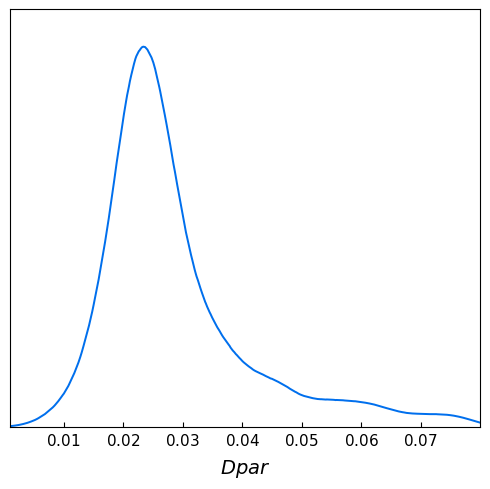

In [52]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["Dpar"], filled=True)
print(np.shape(gdsamples[1]))

In [53]:
print(gdsamples.samples[np.argmin(gdsamples.loglikes)])

[ 0.02333034 -6.42581776 -6.42581776]


In [27]:
def cobaya_com6(omb,omc,h,tau,ns,AS):
    return (10 - np.log(Cosmo_Power(omb,omc,h,tau,ns,AS)))

In [ ]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com1}}
info["params"] = {
   "omb": {"prior": {"min": 0.001, "max": 0.08}, "ref": 0.022, "proposal": 0.005},
    "omc": {"prior": {"min": 0, "max": 0.5}, "ref": 0.12, "proposal": 0.05},
    "h": {"prior": {"min": 50, "max": 80}, "ref": 66, "proposal": 0.5},
    "tau": {"prior": {"min": 0.01, "max": 0.06}, "ref": 0.054, "proposal": 0.005},
    "ns": {"prior": {"min": 0.3, "max": 1.5}, "ref": 0.945, "proposal": 0.005},
    "AS": {"prior": {"min": 1.5, "max": 2.5}, "ref": 2.0196, "proposal": 0.001}}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.01, "max_tries": 1000}}
updated_info, sampler = run(info)

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
(488640,)


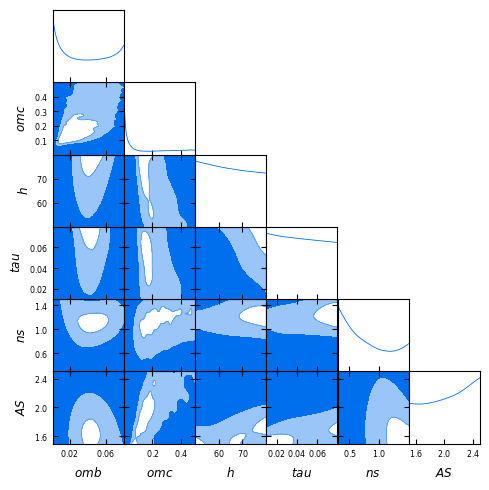

In [31]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb","omc","h","tau","ns","AS"], filled=True)
print(np.shape(gdsamples[6]))

In [ ]:
def cobaya_com2(omb,omc):
    return (10-np.log(Cosmo_Power(omb,omc,66.78,0.0554,0.945,2.096)))
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com2}}
info["params"] = {
   "omb": {"prior": {"min": 0.001, "max": 0.03}, "ref": 0.022, "proposal": 0.001},
    "omc": {"prior": {"min": 0.01, "max": 0.4}, "ref": 0.12, "proposal": 0.01},
    
    }
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.0001, "max_tries": 1000}}
st = time.time()
updated_info, sampler = run(info)
et = time.time()
print(time_hr(et-st))

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
(27520,)


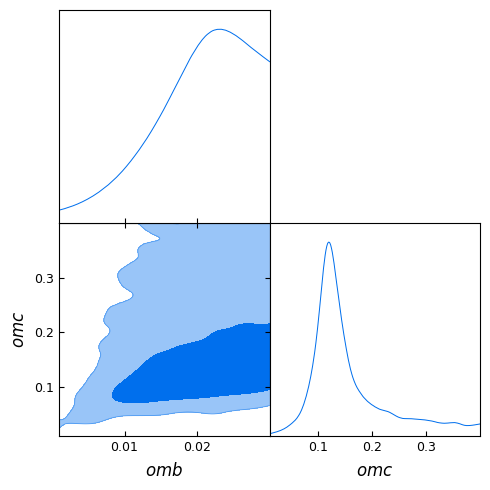

In [4]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb","omc"], filled=True)
print(np.shape(gdsamples[2]))

In [5]:
print(gdsamples.samples[np.argmin(gdsamples.loglikes)])

[ 0.02209514  0.1199604  -6.96444065 -6.96444065]


In [44]:
def cobaya_com3(omb,omc,h):
    return (10-np.log(Cosmo_Power(omb,omc,h,0.0554,0.945,2.096)))

In [ ]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com3}}
info["params"] = {
   "omb": {"prior": {"min": 0.001, "max": 0.03}, "ref": 0.022, "proposal": 0.005},
    "omc": {"prior": {"min": 0.01, "max": 0.4}, "ref": 0.12, "proposal": 0.05},
    "h": {"prior": {"min": 30, "max": 90}, "ref": 66, "proposal": 0.05},
    }
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.0001, "max_tries": 1000}}
st = time.time()
updated_info, sampler = run(info)
et = time.time()
print(time_hr(et-st))

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
(156600,)


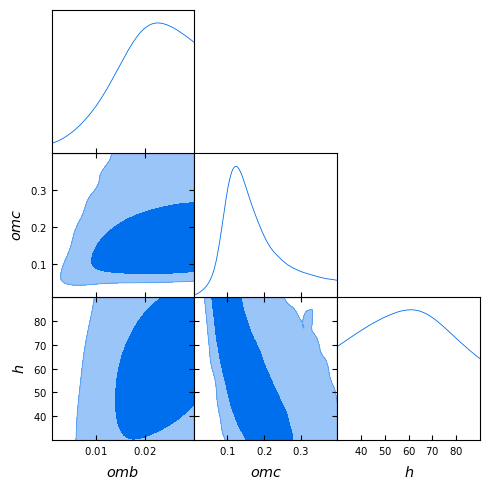

In [46]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb","omc","h"], filled=True)
print(np.shape(gdsamples[3]))

In [8]:
print(gdsamples.samples[np.argmin(gdsamples.loglikes)])
'''omb = 2.21288666e-02 = 0.02212886
omc =   1.20355924e-01 = 0.120355924
H =   6.66347140e+01 = 66.6347'''

[ 0.02209514  0.1199604  -6.96444065 -6.96444065]
